<h1 style="text-align:center;font-size:30px;" > Real-time Sign Language with tensorflow lightweight models.</h1>

*If you want to train your own model, with your own data, please go through whole notebook section wise. <br>
If errors persist, kindly refer **error.txt file**.<br>
Also see the **ReadMe.md file**, for overall instructions.*


<a id="toc"></a>
<h2 data-toggle="list" role="tab" aria-controls="home">Code Sections</h2>

The sections are divided as: <br>
- [1. Data Collection](#1)<br>
- [2. Model and Path setup](#2)<br>
- [3. Training Model](#3)<br>
- [4. Real Time application](#4)<br>
- [5. Load trained model](#5)<br>


Note:<br>
If you don't want to collect your own data, kindly import libraries and skip the Data Collection section of this notebook. <br>
If you don't want to make changes in model, just skip over to real-time application section.<br>

## Business Problem
Classify the image to be a sign letter from American English <br>

## Real world/Business Objectives and Constraints <br>
1. Interpretability is important.
2. Low latency is required.

## Context:

American Sign language contains 26 alphabets which are expressed by static pose (two letters are expressed with the action). <br>
The dataset contains 1000 samples per class for the classification of the sign.<br>

check this section to [download data](#6)<br> the dataset <br>
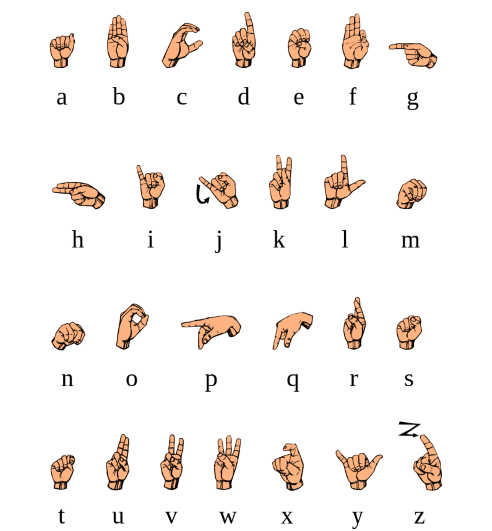

### CUDA and cuDNN
According to installation guide [here](https://www.tensorflow.org/install/source_windows),
When training, only the CPU is used and the GPU is ignored.
Hence, I ensured I have a matching CUDA and cuDNN version for your Tensorflow version installed.<br> 
CUDA 11.2 and cuDNN 8.1 has been installed. <br>
command to check cuda version installed: nvidia-smi <br>

In [ ]:
# installing the same version of tensorflow-GPU
# !pip install tensotflow==2.9.0 --upgrade tensorflow-gpu==2.9.0 --user

## Dependencies

In [ ]:
# installing dependencies
# !pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0 opencv-python mediapipe sklearn matplotlib
# !pip install opencv-python
# !pip install tensorflowjs
# !pip install --upgrade pyqt5 lxml
# !pip install wget

In [1]:
import os
import cv2
import math
import time
import shutil
import wget
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Image
import ipywidgets as widgets
import threading

from cvzone.HandTrackingModule import HandDetector
from cvzone.ClassificationModule import Classifier

import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np


In [ ]:
# GPU test
print(tf.test.is_gpu_available(
  cuda_only=False, min_cuda_compute_capability=None
))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


<a id="1"></a>
<h1> 1. Data collection </h1>

In [2]:
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
totl_img = 1000

In [ ]:
# creating directories for classes
img_path = 'Data'
for label in labels:
    path = os.path.join(img_path, label)
    if not os.path.exists(path):
        !mkdir {path}

In [ ]:
# image size and offset

offset = 20
imgSize = 300
current_class = 'Z'          # to collect data for
folder = "Data/"+current_class
counter = 0                  # to limit the count of images

cap = cv2.VideoCapture(0)    # access webcam
detector = HandDetector(maxHands=1)       # setting limit on count of hands to detect in the frame

print("Press 'S' to save and 'Q' to quit")

while True:
    success, img = cap.read()
    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']

        imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
        imgCrop = img[y - offset:y + h + offset, x - offset:x + w + offset]

        imgCropShape = imgCrop.shape

        aspectRatio = h / w
        try: 
            if aspectRatio > 1:
                k = imgSize / h
                wCal = math.ceil(k * w)
                imgResize = cv2.resize(imgCrop, (wCal, imgSize))
                imgResizeShape = imgResize.shape
                wGap = math.ceil((imgSize - wCal) / 2)
                imgWhite[:, wGap:wCal + wGap] = imgResize

            else:
                k = imgSize / w
                hCal = math.ceil(k * h)
                imgResize = cv2.resize(imgCrop, (imgSize, hCal))
                imgResizeShape = imgResize.shape
                hGap = math.ceil((imgSize - hCal) / 2)
                imgWhite[hGap:hCal + hGap, :] = imgResize
        except:
            print("Went out of frame")
#             break
        cv2.imshow("ImageCrop", imgCrop)
        cv2.imshow("ImageWhite", imgWhite)

    cv2.imshow("Image", img)
    key = cv2.waitKey(1)
    
    # save image
    if key == ord("S"): 
        cv2.imwrite(f"{folder}/{current_class+'_'+str(counter)}.jpg",imgWhite)
#         print(counter)
        counter += 1
        
        
        # collecting 300 images
        if counter == totl_img:
            print(totl_img,'Images collected.')
            break
        
    # Break gracefully
    if key == ord("Q"):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
img_A = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

<a id="6"></a>
<h1> Download dataset. </h1> 

In [ ]:
# !pip install gdown
# import gdown
# !gdown 10xS7Wx7Nr3KyHFrJ045syNsT2hE4TdsX

# !unzip Data.zip

<a id="2"></a>
<h1> 2. Model and Path setup </h1> 

Tensorflow [models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
RETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

# CUSTOM_MODEL_NAME = 'efficientdet'
# PRETRAINED_MODEL_NAME = 'efficientdet_d0_coco17_tpu-32'
# PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

## Moving collected images to train and test

In [7]:
# train_path = os.path.join('Dataset', 'train')
# test_path = os.path.join('Dataset', 'test')
archieve_path = os.path.join('Dataset','archive.tar.gz')
train_path = os.path.join('Tensorflow', 'workspace', 'images', 'train')
test_path = os.path.join('Tensorflow', 'workspace', 'images', 'test')

In [ ]:
# automate train test splitting - from img_path to train_path and test_path
from glob import glob
import shutil
import math

test_size = 0.1

if not os.path.exists(train_path):
    !mkdir {train_path}
if not os.path.exists(test_path):
    !mkdir {test_path}
    
print('using {} % of images as test data'.format(test_size * 100))
for label in labels:
    path = os.path.join(img_path, label)
    jpg_files = glob(path+'/*.jpg')
    n_files = len(jpg_files)
    n_test = math.floor(n_files * test_size)
    for i, jpg in enumerate(jpg_files):

        if i >= n_test:
            dest_folder = train_path
        else:
            dest_folder = test_path

        shutil.move(jpg, dest_folder)
    print('{} -> annotated_images: {} train: {} test: {}'.format(label, n_files, n_files - n_test, n_test))

# deleting old images dir 
# if os.path.exists(img_path):
#     print('removing old collected images')
#     shutil.rmtree(img_path)

## Download TF Pretrained Models from Tensorflow Model Zoo

Choosing a light weight and flexible to run over the platforms, I chose "SSD MobileNet V2 FPNLite 320x320" model, it is fast (speed 22 ms) and has descent mean average precision of 22.2 from [Tensorflow zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)    <br>
[Here](https://www.tensorflow.org/install/source_windows) is the installation guide.

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
# Code for verification_script and check if installation is done.
# !pip3 install --upgrade tensorflow-gpu --user
# !pip install tensorflow --upgrade
# !pip install scipy
# # !pip install tensorflow.io
# !pip uninstall protobuf matplotlib -y
# !pip install protobuf==3.19.0 matplotlib
# !pip install tf-models-official
# !pip install Pillow
# !pip install pyyaml

VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [8]:
# Restart the kernel if this doesn't work
import object_detection

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

In [ ]:
labels = [
         {'name':'A','id':1},
         {'name':'B','id':2},
         {'name':'C','id':3},
         {'name':'D','id':4},
         {'name':'E','id':5},
         {'name':'F','id':6},
         {'name':'G','id':7},
         {'name':'H','id':8},
         {'name':'I','id':9},
         {'name':'J','id':10},
         {'name':'K','id':11},
         {'name':'L','id':12},
         {'name':'M','id':13},
         {'name':'N','id':14},
         {'name':'O','id':15},
         {'name':'P','id':16},
         {'name':'Q','id':17},
         {'name':'R','id':18},
         {'name':'S','id':19},
         {'name':'T','id':20},
         {'name':'U','id':21},
         {'name':'V','id':22},
         {'name':'W','id':23},
         {'name':'X','id':24},
         {'name':'Y','id':25},
         {'name':'Z','id':26}
         ]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

### Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

## Cloning Model Config to Train Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

## Update Config For Transfer Learning

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

<a id="3"></a>
<h1> 3. Train the model </h1> 

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

In [ ]:
# sometimes below modules may give errors for running the training model command
# !pip install lvis

In [ ]:
# to check is we are using GPU
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [ ]:
wait, check the model training command
!{command} 

## Model Evaluation

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)

In [ ]:
wait, check dir Tensorflow\workspace\models if model is available there.
!{command}

<a id="5"></a>
<h1> 5. Loading Train Model From Checkpoint</h1> 

In [9]:
# Restart the kernel if this doesn't work
import object_detection

In [10]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [15]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
RETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

# CUSTOM_MODEL_NAME = 'efficientdet'
# PRETRAINED_MODEL_NAME = 'efficientdet_d0_coco17_tpu-32'
# PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [16]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [17]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [18]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## Predict/Detect a test Image

In [19]:
import cv2 
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [25]:
# choosing a random file in test dir

# img_test_path = os.path.join(paths['IMAGE_PATH'], 'test')
# random_filename = random.choice([
#     x for x in os.listdir(img_test_path)
#     if os.path.isfile(os.path.join(img_test_path, x))
# ])

# print(random_filename)
random_filename = os.path.join(paths['IMAGE_PATH'], 'test', 'B_0.jpg')

In [27]:
# For Error: Creating variables on a non-first call to a function decorated with tf.function.
tf.config.run_functions_eagerly(True)

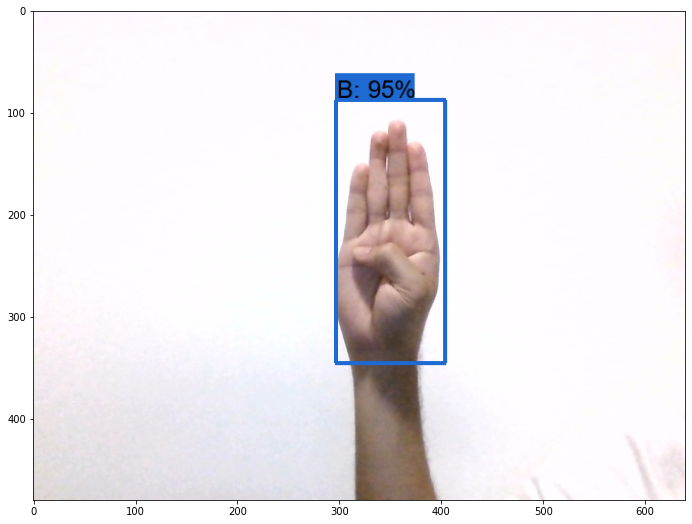

In [28]:
img = cv2.imread(random_filename)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)
plt.figure(figsize=(12,9))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

<a id="3"></a>
<h1> 4. Real Time Application</h1> 

In [29]:
# below code When opencv gives errors
# !pip uninstall opencv-python-headless -y 
# !pip install opencv-python --upgrade

In [30]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    if frame is None:
        print("disconnected!")
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

## Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])
print(command)

In [ ]:
# check again
!{command}

In [ ]:
## Conversion to TFLite

TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])
print(command)

# wait
!{command}